In [1]:
# Mounting drive
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


### Environment Setup

First, download the code and pretrained models if we are on colab.

In [2]:
import glob, os, cv2, shutil
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image, ImageFilter 
from skimage import morphology
os.chdir("/content/gdrive/My Drive/segmentation")
!ls

config		      encoder_epoch_20.pth  mit_semseg	      teaser
data		      eval_multipro.py	    notebooks	      test.py
decoder_epoch_20.pth  eval.py		    README.md	      train.py
demo_test.sh	      install.log	    requirements.txt
download_ADE20K.sh    LICENSE		    setup.py


In [3]:
# %%bash
# # Colab-specific setup
# !(stat -t /usr/local/lib/*/dist-packages/google/colab > /dev/null 2>&1) && exit 
# pip install yacs 2>&1 >> install.log
# git init 2>&1 >> install.log
# git remote add origin https://github.com/CSAILVision/semantic-segmentation-pytorch.git 2>> install.log
# git pull origin master 2>&1 >> install.log
# DOWNLOAD_ONLY=1 ./demo_test.sh 2>> install.log

In [4]:
# System libs
import os, csv, torch, numpy, scipy.io, PIL.Image, torchvision.transforms
# Our libs
from mit_semseg.models import ModelBuilder, SegmentationModule
from mit_semseg.utils import colorEncode

colors = scipy.io.loadmat('data/color150.mat')['colors']
names = {}
with open('data/object150_info.csv') as f:
    reader = csv.reader(f)
    next(reader)
    for row in reader:
        names[int(row[0])] = row[5].split(";")[0]

def visualize_result(img, pred, index=None):
    # filter prediction class if requested
    if index is not None:
        pred = pred.copy()
        pred[pred != index] = -1
        print(f'{names[index+1]}:')
        
    # colorize prediction
    pred_color = colorEncode(pred, colors).astype(numpy.uint8)

    # aggregate images and save
    im_vis = numpy.concatenate((img, pred_color), axis=1)
    display(PIL.Image.fromarray(im_vis))

## Loading the segmentation model

In [5]:
# Network Builders
net_encoder = ModelBuilder.build_encoder(
    arch='resnet50dilated',
    fc_dim=2048,
    weights='encoder_epoch_20.pth')
net_decoder = ModelBuilder.build_decoder(
    arch='ppm_deepsup',
    fc_dim=2048,
    num_class=150,
    weights='decoder_epoch_20.pth',
    use_softmax=True)

crit = torch.nn.NLLLoss(ignore_index=-1)
segmentation_module = SegmentationModule(net_encoder, net_decoder, crit)
segmentation_module.eval()
segmentation_module.cuda()

Loading weights for net_encoder
Loading weights for net_decoder


SegmentationModule(
  (encoder): ResnetDilated(
    (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn1): SynchronizedBatchNorm2d(64, eps=1e-05, momentum=0.001, affine=True, track_running_stats=True)
    (relu1): ReLU(inplace=True)
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): SynchronizedBatchNorm2d(64, eps=1e-05, momentum=0.001, affine=True, track_running_stats=True)
    (relu2): ReLU(inplace=True)
    (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn3): SynchronizedBatchNorm2d(128, eps=1e-05, momentum=0.001, affine=True, track_running_stats=True)
    (relu3): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(128, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): SynchronizedBatchNorm2d(64, eps=1

## Load test data

Now we load and normalize a single test image.  Here we use the commonplace convention of normalizing the image to a scale for which the RGB values of a large photo dataset would have zero mean and unit standard deviation.  (These numbers come from the imagenet dataset.)  With this normalization, the limiiting ranges of RGB values are within about (-2.2 to +2.7).

In [6]:
# Load and normalize one image as a singleton tensor batch
pil_to_tensor = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(
        mean=[0.485, 0.456, 0.406], # These are RGB mean+std values
        std=[0.229, 0.224, 0.225])  # across a large photo dataset.
])

## version4: people, car, bus, truck mask + path edges (smooth)

In [9]:
def get_houghlines(edges):
  kernel = np.ones((10,10), np.uint8)
  edge_history = cv2.HoughLinesP(edges.astype("uint8"),1,np.pi/180,15,minLineLength=minLineLength,maxLineGap=maxLineGap)
  edge_combined = np.zeros(edges.shape)
  try:
    for x in range(0, len(edge_history)):
      for x1,y1,x2,y2 in edge_history[x]:
        if np.abs(x1-x2)>5 and np.abs(y1-y2)>5:# we don't want edges in the border
          cv2.line(edge_combined,(x1,y1),(x2,y2),color = (255, 255, 255))
    edge_combined = cv2.dilate(edge_combined, kernel, iterations=1)
  except (RuntimeError, TypeError, NameError):
    print("no lines")
  return edge_combined

In [11]:
vid_path = "/content/gdrive/My Drive/291 Bionic Vision Project/Asa&Devi_Video/New Stimuli/Videos"
all_folders = glob.glob("%s/*_frames" %vid_path)
all_folders.sort()
all_folders[5:8]

['/content/gdrive/My Drive/291 Bionic Vision Project/Asa&Devi_Video/New Stimuli/Videos/stim15_orig_frames',
 '/content/gdrive/My Drive/291 Bionic Vision Project/Asa&Devi_Video/New Stimuli/Videos/stim16_orig_frames',
 '/content/gdrive/My Drive/291 Bionic Vision Project/Asa&Devi_Video/New Stimuli/Videos/stim1_orig_frames']

stim15
frame 1


PermissionError: ignored

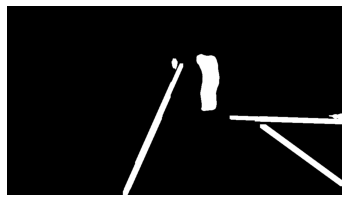

In [12]:
vid_path = "/content/gdrive/My Drive/291 Bionic Vision Project/Asa&Devi_Video/New Stimuli/Videos"
all_folders = glob.glob("%s/*_frames" %vid_path)
all_folders.sort()
all_folders = all_folders[5:8]
for f in all_folders: #each video
  stim_name = f.split("/")[-1].split("_")[0]
  print(stim_name)
  all_frames = glob.glob("%s/*.jpg" %f)
  
  W = 10
  w_count = 0
  mask_rep = np.zeros((4,540, 960, W)) #num_class x hieght x width x windowsize
  #classes in order [12,20,80,83] people, car, bus, truck
  edge_rep = np.zeros((540, 960, W))

  for count in np.arange(1,len(all_frames)): #each frame
    f_name = f + "/frame%d.jpg" %count
    pil_image = PIL.Image.open(f_name).convert('RGB')
    img_original = numpy.array(pil_image)
    img_data = pil_to_tensor(pil_image)
    singleton_batch = {'img_data': img_data[None].cuda()}
    output_size = img_data.shape[1:]

    with torch.no_grad():
      scores = segmentation_module(singleton_batch, segSize=output_size)

    # Get the predicted scores for each pixel
    _, pred = torch.max(scores, dim=1)
    pred = pred.cpu()[0].numpy()
    # visualize_result(img_original, pred)

    # filter out other classes
    classes = [6, 11, 12, 13, 17, 20] #road, sidewalk, person, earth, plant, car
    pred_clean = pred.copy()
    pred_clean[~np.isin(pred_clean, classes)]= 0

    # filter out small islands
    pred_clean2 = morphology.remove_small_objects(pred_clean.astype(bool), min_size=16000).astype(int)*255

    # combine mask with correct class labels
    pred_clean3 = np.minimum(pred_clean, pred_clean2)

    # get structure edges and get only long ones
    image = Image.fromarray(np.uint8(pred_clean3 * 255) , 'L')
    image_edge = image.filter(ImageFilter.FIND_EDGES) 
    image_edge = np.array(image_edge)
    kernel = np.ones((10,10), np.uint8)
    image_edge = cv2.dilate(image_edge, kernel, iterations=1)

    minLineLength = 200
    maxLineGap = 2
    lines = cv2.HoughLinesP(image_edge,1,np.pi/180,15,minLineLength=minLineLength,maxLineGap=maxLineGap)
    edges = np.zeros(pred_clean3.shape)
    try:
      for x in range(0, len(lines)):
        for x1,y1,x2,y2 in lines[x]:
          if x1!=x2 and y1!=y2:# we don't want edges in the border
            cv2.line(edges,(x1,y1),(x2,y2),color = (255, 255, 255))
      edges = cv2.dilate(edges, kernel, iterations=1)
    except (RuntimeError, TypeError, NameError):
      print("no lines")
    
    ##############
    if count <= W: 
      edge_rep[:,:,count-1] = edges
    else:
      #update current edge
      hist_curr = np.concatenate([edge_rep, np.expand_dims(edges,2)], axis = 2)
      hist_curr = np.max(hist_curr, axis = 2)
      plt.imshow(hist_curr)
      hist_curr = cv2.erode(get_houghlines(hist_curr), np.ones((10,10)))
      plt.imshow(hist_curr)
      kernel2 = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (2, 2))
      (thresh, binRed) = cv2.threshold(hist_curr, 0, 255, cv2.THRESH_BINARY)
      hist_curr = cv2.morphologyEx(hist_curr, cv2.MORPH_OPEN, kernel2, iterations=3)
      hist_curr = cv2.erode(get_houghlines(hist_curr), np.ones((10,10)))
      edges = hist_curr
      plt.imshow(edges)
    ##############

    # update pred
    pred = pred_clean3
    allcounts = numpy.bincount(pred.flatten())
    predicted_classes = numpy.bincount(pred.flatten()).argsort()[::-1]
    predicted_classes = [c for c in predicted_classes if c in [12, 20, 80, 83]] #mask only for person car, bus, truck
    classes_order = [12,20,80,83]
    mask_count = 1
    final_mask = np.zeros(pred.shape)
    for c in predicted_classes:
      class_name = names[c+1]
      mask_c = pred.copy()
      mask_c[mask_c == c] = 255
      mask_c[mask_c != 255] = 0
      mask_c = mask_c.astype(np.uint8)
      mask_size = len(np.where(mask_c==255)[0])
      
      if c==12 and mask_size>0: # find elongated direction for person
        # find outer contour
        ret, thresh = cv2.threshold(mask_c,0,255,0)
        cntrs = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        cntrs = cntrs[0] if len(cntrs) == 2 else cntrs[1]

        # get rotated rectangle from outer contour
        rotrect = cv2.minAreaRect(cntrs[0])
        box = cv2.boxPoints(rotrect)
        box = np.int0(box)
        # get angle from rotated rectangle
        angle = rotrect[-1]
        if np.abs(angle) < 60: #if the person elongated direction is horizontal, skip it (probably false alarm)
          mask_c = np.zeros(pred.shape)

      #############
      # update mask and edge repo
      # if not seen 10 frames yet (count starts from 1)
      if count <= W: 
        c_idx = classes_order.index(c)
        mask_rep[c_idx, :,:,count-1] = mask_c
      else: 
        c_idx = classes_order.index(c)
        #1.find masks existed in the past
        mask_max = np.max(mask_rep[0, :,:,:], axis = 2)
        if mask_size == 0: # if the newest frame does not detect class
          mask_c = mask_max.copy()
        #2.update mask repository
        mask_old  = mask_rep[c_idx, :,:,:]
        mask_new = np.concatenate([mask_old, np.expand_dims(mask_c, axis = 2)], axis = 2)
        mask_new = np.delete(mask_new, 0, 2)
        mask_rep[c_idx,:,:,:] = mask_new
      #############


      # print("{} size {}".format(class_name, mask_size))
      if mask_count == 1:
        final_mask = mask_c
        final_mask = np.expand_dims(final_mask, axis=2)
        mask_count +=1
      else:
        final_mask = np.concatenate([final_mask, np.expand_dims(mask_c, axis=2)], axis = 2)
        mask_count +=1

    if len(final_mask.shape)==3:
      final_mask = np.concatenate([final_mask, np.expand_dims(edges, axis=2)], axis = 2)
      final_mask = np.max(final_mask, axis = 2)
    else:
      final_mask = np.concatenate([np.expand_dims(final_mask,axis=2), np.expand_dims(edges, axis=2)], axis = 2)
      final_mask = np.max(final_mask, axis = 2)

    if os.path.isdir("%s/temp_mask_edge" %(f))== False:
      os.mkdir("%s/temp_mask_edge" %(f))

    print("frame %d" %count)
    plt.imshow(final_mask, "gray")
    plt.axis("off")
    filename = "frame_%d_seg.jpg" %count
    plt.savefig("%s/temp_mask_edge/%s" %(f,filename), bbox_inches='tight', pad_inches=0)

    count +=1

  print("%s finished" %stim_name)

##version 1: contours

In [ ]:
import moviepy.editor as mp
from skimage import feature
from PIL import Image


vid_path = "/content/gdrive/My Drive/291 Bionic Vision Project/Asa&Devi_Video/New Stimuli/Videos"
all_folders = glob.glob("%s/*_frames" %vid_path)
for f in all_folders: #each video
  stim_name = f.split("/")[-1].split("_")[0]
  print(stim_name)
  all_frames = glob.glob("%s/*.jpg" %f)
  
  for count in np.arange(1,len(all_frames)): #each frame
    f_name = f + "/frame%d.jpg" %count
    pil_image = PIL.Image.open(f_name).convert('RGB')
    img_original = numpy.array(pil_image)
    img_data = pil_to_tensor(pil_image)
    singleton_batch = {'img_data': img_data[None].cuda()}
    output_size = img_data.shape[1:]
    
    with torch.no_grad():
      scores = segmentation_module(singleton_batch, segSize=output_size)

    # Get the predicted scores for each pixel
    _, pred = torch.max(scores, dim=1)
    pred = pred.cpu()[0].numpy()
    # visualize_result(img_original, pred)

    allcounts = numpy.bincount(pred.flatten())
    predicted_classes = numpy.bincount(pred.flatten()).argsort()[::-1]
    
    mask_count = 1
    for c in predicted_classes[:15]:
      mask_c = pred.copy()
      mask_c[mask_c != c] = 0
      mask_c[mask_c == c] = 255
      mask_c = mask_c.astype(np.uint8)

      #get edges
      edges = feature.canny(mask_c, sigma=10).astype("uint8")
      kernel = np.ones((10,10), np.uint8) 
      edges = cv2.dilate(edges,kernel)

      #get individual contours
      kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3,3))
      opening = cv2.morphologyEx(mask_c, cv2.MORPH_OPEN, kernel, iterations=1)
      cnts = cv2.findContours(opening, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
      cnts = cnts[0] if len(cnts) == 2 else cnts[1]
      num_contors = len(cnts) 

      mask_size = len(np.where(mask_c==255)[0])
      # if it's not road, sky and mask size is large enough
      if c not in [1, 2, 6, 16] and mask_size >5000 and num_contors < 6:
        # print(c)
        # print(mask_size)
        if mask_count == 1:
          final_edges = edges
          final_edges = np.expand_dims(final_edges, axis=2)
          mask_count +=1
        else:
          final_edges = np.concatenate([final_edges, np.expand_dims(edges, axis=2)], axis = 2)
          mask_count +=1

    if len(final_edges.shape)==3:
      final_edges = np.max(final_edges, axis = 2)

    if os.path.isdir("%s/temp" %(f))== False:
      os.mkdir("%s/temp" %(f))
    print("frame %d" %count)
    plt.imshow(final_edges, "gray")
    plt.axis("off")
    filename = "frame_%d_seg.jpg" %count
    plt.savefig("%s/temp/%s" %(f,filename), bbox_inches='tight', pad_inches=0)
    count +=1
  
  print("%s finished" %stim_name)

## version2: mask + edges


In [ ]:
from skimage import morphology
vid_path = "/content/gdrive/My Drive/291 Bionic Vision Project/Asa&Devi_Video/New Stimuli/Videos"
all_folders = glob.glob("%s/*_frames" %vid_path)
all_folders = all_folders[5:9]

for f in all_folders: #each video
  stim_name = f.split("/")[-1].split("_")[0]
  print(stim_name)
  all_frames = glob.glob("%s/*.jpg" %f)
  
  # W = 10
  # Mask_rep = {} 
  # mask repository that is gonna been updated:
  # key is the class-name
  # value is 3d array : 2d mask x #frames(W)

  for count in np.arange(1,len(all_frames)): #each frame
    f_name = f + "/frame%d.jpg" %count
    pil_image = PIL.Image.open(f_name).convert('RGB')
    img_original = numpy.array(pil_image)
    img_data = pil_to_tensor(pil_image)
    singleton_batch = {'img_data': img_data[None].cuda()}
    output_size = img_data.shape[1:]

    with torch.no_grad():
      scores = segmentation_module(singleton_batch, segSize=output_size)

    # Get the predicted scores for each pixel
    _, pred = torch.max(scores, dim=1)
    pred = pred.cpu()[0].numpy()
    # visualize_result(img_original, pred)

    # filter out other classes
    classes = [1, 4, 11, 12, 17, 20, 51, 52, 80, 83, 128]
    pred_clean = pred.copy()
    pred_clean[~np.isin(pred_clean, classes)]= 0

    # filter out small islands
    pred_clean2 = morphology.remove_small_objects(pred_clean.astype(bool), min_size=5000).astype(int)*255

    # combine mask with correct class labels
    pred_clean3 = np.minimum(pred_clean, pred_clean2)

    # update pred
    pred = pred_clean3
    allcounts = numpy.bincount(pred.flatten())
    predicted_classes = numpy.bincount(pred.flatten()).argsort()[::-1]

    mask_count = 1
    for c in predicted_classes[:11]:
      class_name = names[c+1]
      mask_c = pred.copy()
      mask_c[mask_c == c] = 255
      mask_c[mask_c != 255] = 0
      mask_c = mask_c.astype(np.uint8)
      mask_size = len(np.where(mask_c==255)[0])
      # if count < W: #if not observed 10 frames yet
      #   if class_name not in Mask_rep.keys():
      #     Mask_rep[class_name] = np.zeros([540, 960, W])
      #     Mask_rep[class_name][:,:,0] = mask_c
      #   else:
      #     Mask_rep[class_name][:,:,(count % W-1)] = mask_c
      # else:
      #   if class_name not in Mask_rep.keys():
      #     Mask_rep[class_name] = np.zeros([540, 960, W])
      #     Mask_rep[class_name][:,:,0] = mask_c
      if mask_size > 50000 and mask_size < 100000:
        # print("{} size {}".format(class_name, mask_size))
        if mask_count == 1:
          final_mask = mask_c
          final_mask = np.expand_dims(final_mask, axis=2)
          mask_count +=1
        else:
          final_mask = np.concatenate([final_mask, np.expand_dims(mask_c, axis=2)], axis = 2)
          mask_count +=1

    if len(final_mask.shape)==3:
      final_mask = np.max(final_mask, axis = 2)

    if os.path.isdir("%s/temp_mask" %(f))== False:
      os.mkdir("%s/temp_mask" %(f))

    print("frame %d" %count)
    plt.imshow(final_mask, "gray")
    plt.axis("off")
    filename = "frame_%d_seg.jpg" %count
    plt.savefig("%s/temp_mask/%s" %(f,filename), bbox_inches='tight', pad_inches=0)

    count +=1

  print("%s finished" %stim_name)

## version 3 only people, car, path edges

In [ ]:
vid_path = "/content/gdrive/My Drive/291 Bionic Vision Project/Asa&Devi_Video/New Stimuli/Videos"
all_folders = glob.glob("%s/*_frames" %vid_path)
all_folders = all_folders[8:12]
for f in all_folders: #each video
  stim_name = f.split("/")[-1].split("_")[0]
  print(stim_name)
  all_frames = glob.glob("%s/*.jpg" %f)
  
  # W = 10
  # Mask_rep = {} 
  # mask repository that is gonna been updated:
  # key is the class-name
  # value is 3d array : 2d mask x #frames(W)

  for count in np.arange(1,len(all_frames)): #each frame
    f_name = f + "/frame%d.jpg" %count
    pil_image = PIL.Image.open(f_name).convert('RGB')
    img_original = numpy.array(pil_image)
    img_data = pil_to_tensor(pil_image)
    singleton_batch = {'img_data': img_data[None].cuda()}
    output_size = img_data.shape[1:]

    with torch.no_grad():
      scores = segmentation_module(singleton_batch, segSize=output_size)

    # Get the predicted scores for each pixel
    _, pred = torch.max(scores, dim=1)
    pred = pred.cpu()[0].numpy()
    # visualize_result(img_original, pred)

    # filter out other classes
    classes = [6, 11, 12, 13, 17, 20] #road, sidewalk, person, earth, plant, car
    pred_clean = pred.copy()
    pred_clean[~np.isin(pred_clean, classes)]= 0

    # filter out small islands
    pred_clean2 = morphology.remove_small_objects(pred_clean.astype(bool), min_size=16000).astype(int)*255

    # combine mask with correct class labels
    pred_clean3 = np.minimum(pred_clean, pred_clean2)

    # get structure edges and get only long ones
    image = Image.fromarray(np.uint8(pred_clean3 * 255) , 'L')
    image_edge = image.filter(ImageFilter.FIND_EDGES) 
    image_edge = np.array(image_edge)
    kernel = np.ones((10,10), np.uint8)
    image_edge = cv2.dilate(image_edge, kernel, iterations=1)

    minLineLength = 200
    maxLineGap = 2
    lines = cv2.HoughLinesP(image_edge,1,np.pi/180,15,minLineLength=minLineLength,maxLineGap=maxLineGap)
    edges = np.zeros(pred_clean3.shape)
    try:
      for x in range(0, len(lines)):
        for x1,y1,x2,y2 in lines[x]:
          cv2.line(edges,(x1,y1),(x2,y2),color = (255, 255, 255))
      edges = cv2.dilate(edges, kernel, iterations=1)
    except (RuntimeError, TypeError, NameError):
      print("no lines")

    # update pred
    pred = pred_clean3
    allcounts = numpy.bincount(pred.flatten())
    predicted_classes = numpy.bincount(pred.flatten()).argsort()[::-1]
    predicted_classes = [c for c in predicted_classes if c in [12, 20, 80, 83]] #mask only for person car, bus, truck
    mask_count = 1
    final_mask = np.zeros(pred.shape)
    for c in predicted_classes:
      class_name = names[c+1]
      mask_c = pred.copy()
      mask_c[mask_c == c] = 255
      mask_c[mask_c != 255] = 0
      mask_c = mask_c.astype(np.uint8)
      mask_size = len(np.where(mask_c==255)[0])
      
      if c==12 and mask_size>0: # find elongated direction for person
        # find outer contour
        ret, thresh = cv2.threshold(mask_c,0,255,0)
        cntrs = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        cntrs = cntrs[0] if len(cntrs) == 2 else cntrs[1]

        # get rotated rectangle from outer contour
        rotrect = cv2.minAreaRect(cntrs[0])
        box = cv2.boxPoints(rotrect)
        box = np.int0(box)
        # get angle from rotated rectangle
        angle = rotrect[-1]
        if np.abs(angle) < 60: #if the person elongated direction is horizontal, skip it (probably false alarm)
          continue

      # print("{} size {}".format(class_name, mask_size))
      if mask_count == 1:
        final_mask = mask_c
        final_mask = np.expand_dims(final_mask, axis=2)
        mask_count +=1
      else:
        final_mask = np.concatenate([final_mask, np.expand_dims(mask_c, axis=2)], axis = 2)
        mask_count +=1

    if len(final_mask.shape)==3:
      final_mask = np.concatenate([final_mask, np.expand_dims(edges, axis=2)], axis = 2)
      final_mask = np.max(final_mask, axis = 2)
    else:
      final_mask = np.concatenate([np.expand_dims(final_mask,axis=2), np.expand_dims(edges, axis=2)], axis = 2)
      final_mask = np.max(final_mask, axis = 2)

    if os.path.isdir("%s/temp_mask_edge" %(f))== False:
      os.mkdir("%s/temp_mask_edge" %(f))

    print("frame %d" %count)
    plt.imshow(final_mask, "gray")
    plt.axis("off")
    filename = "frame_%d_seg.jpg" %count
    plt.savefig("%s/temp_mask_edge/%s" %(f,filename), bbox_inches='tight', pad_inches=0)

    count +=1

  print("%s finished" %stim_name)

## Make Videos

In [ ]:
import cv2
import numpy as np
import glob
fps = 20
size = (334, 188)

vid_path = "/content/gdrive/My Drive/291 Bionic Vision Project/Asa&Devi_Video/New Stimuli/Videos"
all_folders = glob.glob("%s/*_frames" %vid_path)
for f in all_folders: #each video
  stim_name = f.split("/")[-1].split("_")[0]
  vid_pathOut = vid_path + "/%s_seg.avi" %stim_name
  out = cv2.VideoWriter(vid_pathOut,cv2.VideoWriter_fourcc(*'DIVX'), fps, size)

  allframes = glob.glob('%s/temp/*.jpg' %f)
  for i in np.arange(1,len(allframes)):
    filename = '%s/temp/frame_%d_seg.jpg' %(f,i)
    img = cv2.imread(filename)
    out.write(img)

  out.release()
  print("%s finished" %stim_name)

stim1 finished
stim10 finished
stim11 finished
stim12 finished
stim13 finished
stim14 finished
stim15 finished
stim16 finished
stim2 finished
stim3 finished
stim4 finished
stim5 finished
stim6 finished
stim7 finished
stim8 finished
stim9 finished
